Денні дані для моделі SARIMA готові. Розмір: (1434,)


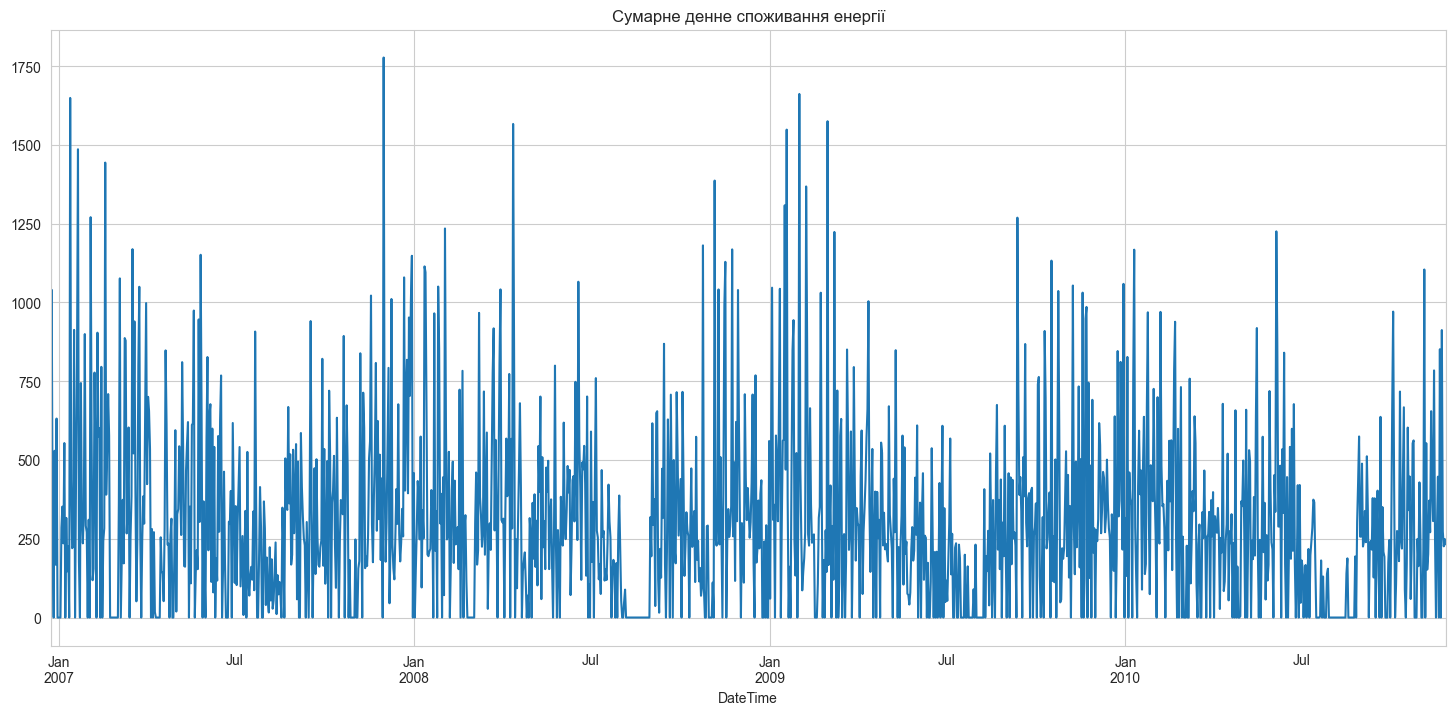

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pmdarima as pm

import joblib

# Налаштування візуалізацій
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (18, 8)

# Завантажуємо фінальний датасет
data_path = '../data/dataset_for_modeling.csv'
df = pd.read_csv(data_path, index_col='DateTime', parse_dates=True)

# Для SARIMA нам потрібен лише один часовий ряд
# Давайте для початку попрацюємо з денними даними, щоб прискорити розрахунки
df_daily = df['Global_active_power'].resample('D').sum()

print("Денні дані для моделі SARIMA готові. Розмір:", df_daily.shape)
df_daily.plot(title='Сумарне денне споживання енергії')
plt.show()

Розмір тренувального набору: 1104
Розмір тестового набору: 330


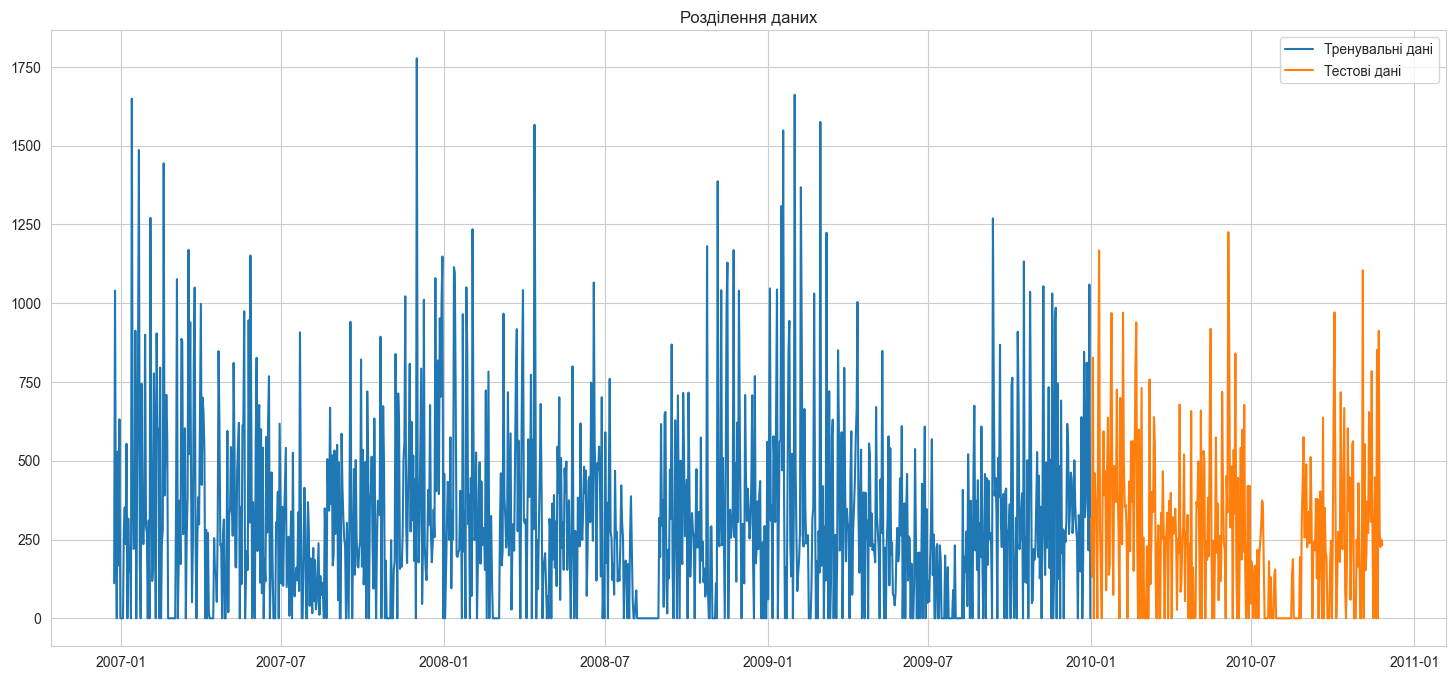

In [2]:
# Візьмемо дані до 2010 року для навчання, а 2010 рік - для тесту
train_data = df_daily.loc[:'2009-12-31']
test_data = df_daily.loc['2010-01-01':]

print(f"Розмір тренувального набору: {len(train_data)}")
print(f"Розмір тестового набору: {len(test_data)}")

# Візуалізуємо розділення
plt.plot(train_data, label='Тренувальні дані')
plt.plot(test_data, label='Тестові дані')
plt.title('Розділення даних')
plt.legend()
plt.show()

In [3]:
# auto_arima автоматично підбере найкращі параметри для моделі SARIMA
# trace=True буде виводити інформацію про процес пошуку
# stepwise=True прискорює пошук
sarima_model = pm.auto_arima(train_data,
                             start_p=1, start_q=1,
                             test='adf',       # тест для визначення d
                             max_p=3, max_q=3, # максимальні p, q
                             m=7,              # частота сезонності (7 днів)
                             d=None,           # нехай модель визначить d сама
                             seasonal=True,    # ввімкнути сезонність
                             start_P=0,
                             D=1,              # D зазвичай 1 для сезонних даних
                             trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=True)

print("\nЗведена інформація про найкращу модель:")
print(sarima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=inf, Time=0.79 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=16031.576, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=15767.646, Time=0.27 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=16029.578, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=16033.362, Time=0.03 sec
 ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=15654.927, Time=0.62 sec
 ARIMA(1,0,0)(2,1,1)[7] intercept   : AIC=inf, Time=1.22 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(0,0,0)(2,1,0)[7] intercept   : AIC=15653.582, Time=0.43 sec
 ARIMA(0,0,0)(1,1,0)[7] intercept   : AIC=15765.770, Time=0.19 sec
 ARIMA(0,0,0)(2,1,1)[7] intercept   : AIC=inf, Time=0.86 sec
 ARIMA(0,0,0)(1,1,1)[7] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(0,0,1)(2,1,0)[7] intercept   : AIC=15655.048, Time=0.54 sec
 ARIMA(1,0,1)(2,1,0)[7] intercept   : AIC=15642.637, Ti

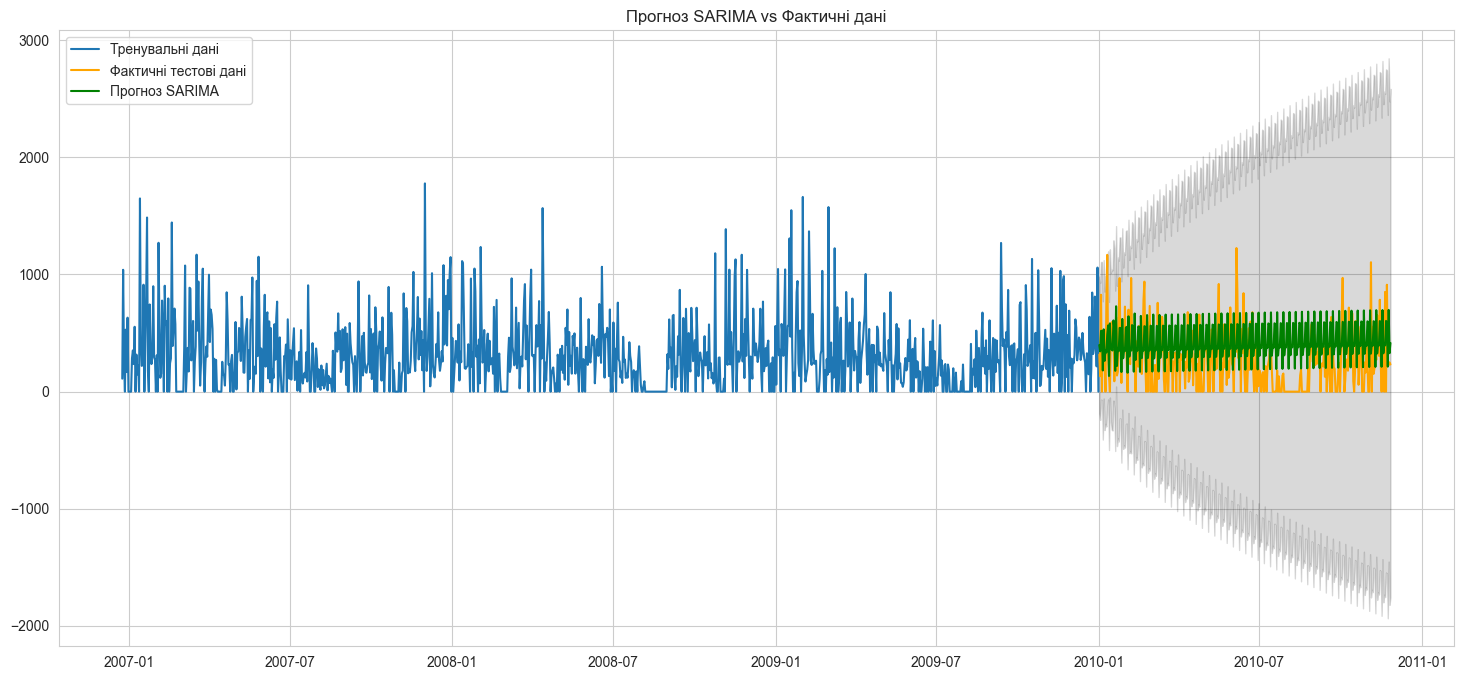

Mean Absolute Error (MAE): 275.60
Root Mean Squared Error (RMSE): 330.52


In [4]:
# Робимо прогноз на кількість кроків, що дорівнює розміру тестового набору
n_periods = len(test_data)
predictions, conf_int = sarima_model.predict(n_periods=n_periods, return_conf_int=True)

# Створюємо DataFrame з прогнозами для зручності
predictions_df = pd.Series(predictions, index=test_data.index)
conf_int_df = pd.DataFrame(conf_int, index=test_data.index, columns=['lower_bound', 'upper_bound'])

# Візуалізація результатів
plt.plot(train_data, label='Тренувальні дані')
plt.plot(test_data, label='Фактичні тестові дані', color='orange')
plt.plot(predictions_df, label='Прогноз SARIMA', color='green')
plt.fill_between(conf_int_df.index,
                 conf_int_df.iloc[:, 0],
                 conf_int_df.iloc[:, 1], color='k', alpha=.15)
plt.title('Прогноз SARIMA vs Фактичні дані')
plt.legend()
plt.show()

# Оцінка точності
mae = mean_absolute_error(test_data, predictions_df)
rmse = np.sqrt(mean_squared_error(test_data, predictions_df))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

In [5]:
# Зберігаємо навчену модель у папку 'models'
model_path = '../models/sarima_baseline_model.pkl'
joblib.dump(sarima_model, model_path)

print(f"Модель SARIMA успішно збережено в: {model_path}")

Модель SARIMA успішно збережено в: ../models/sarima_baseline_model.pkl
